# Model Development - Part III
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

This notebook implements the changes made to the improved architecture from `Model Improvement - Part II`.
- The positive changes are combined to obtain the best performing model.
- GPU can be used.
- Training durations can be compared as training is performed on the same GPU.

- Following are the changes examined -
    - Section One (Augmentations) -
        - Noise addition.
        - Time stretch.
        - Pitch shift.
        - Frequency masking.
        - Time masking.
    - Section Two (Hyperparameter tuning) -
        - Batch size.
        - Dropout.
        - Attention parameter.
        - Task layers.
        - Weight decay.
        - Learning rate decay.
        
The sections are as follows -
- [Load Files](#load_files)
- [Imports](#imports)
- [Data Preparation](#data_preparation)
- [Training Parameters](#training_parameters)
- [Model Parameters](#model_parameters)
- [Overview](#overview)
- [Section I](#section_one)
- [Section II](#section_two)
- [Final Values](#final)

<a id='load_files'></a>
## Load Files
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

- Loading the IEMOCAP Spectrograms, IEMOCAP Meta, network module, visualization module, and helper module into the session storage (for use in Colab).
- Additionally installing `torchmetrics`.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp '/content/gdrive/My Drive/Speech Emotion Recognition Project/IEMOCAP Spectrograms.zip' 'IEMOCAP Spectrograms.zip'
!cp '/content/gdrive/My Drive/Speech Emotion Recognition Project/IEMOCAP Meta.zip' 'IEMOCAP Meta.zip'
!cp '/content/gdrive/My Drive/Speech Emotion Recognition Project/network.zip' 'network.zip'
!cp '/content/gdrive/My Drive/Speech Emotion Recognition Project/visualization.zip' 'visualization.zip'
!cp '/content/gdrive/My Drive/Speech Emotion Recognition Project/helper.zip' 'helper.zip'

!unzip 'IEMOCAP Spectrograms.zip'
!unzip 'IEMOCAP Meta.zip'
!unzip 'network.zip'
!unzip 'visualization.zip'
!unzip 'helper.zip'

!pip install torchmetrics

<a id='imports'></a>
## Imports
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Step 1:
Importing the required functions from the network module.
> `batch` - Code for batch-related operations.<br>
> `train` - Code for training the network.

In [2]:
import sys
sys.path.append('./network')

from network.batch import get_batches
from network.train import get_complex_model, train_complex_network

#### Step 2:
- Importing the required functions from the visualization module.
    > `explanation` - Code for conducting explanatory visualizations.

In [3]:
sys.path.append('./visualization')

from visualization.explanation import compare_complex, plot_complex

#### Step 3:
Importing the required functions from the helper module.
> `common` - Code for general-purpose functions common among all modules.<br>
> `network` - Code for general-purpose functions of network module.

In [4]:
from helper.common import save_data
from helper.network import load_data, get_emotion_num, get_classification_metric, get_regression_metric, get_criterion

<a id='data_preparation'></a>
## Data Preparation
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Step 1:
Loading `split_data`, `class_data`, `stats`, and selected architecture.

In [5]:
root = './IEMOCAP Spectrograms'
meta_root = './IEMOCAP Meta'
roots = (root, meta_root)
name = 'iemocap'

split_data = load_data(meta_root, 'Split')
class_data = load_data(meta_root, 'Class')
stats = load_data(meta_root, 'Statistics')

ARCH = load_data(meta_root, 'Selected')

#### Step 2:
- Obtaining the number of outputs for each task.
- Defining the type of each task.

In [6]:
num_outputs = [get_emotion_num(name, class_data), 2, 1, 1, 1]

tasks = ('Emotions', 'Genders', 'Valence', 'Activation', 'Dominance')
task_type = ('classification', 'classification', 'regression', 'regression', 'regression')

for i, output in enumerate(num_outputs):
    print(f'{tasks[i]}: {output}')

Emotions: 8
Genders: 2
Valence: 1
Activation: 1
Dominance: 1


<a id='training_parameters'></a>
## Training Parameters
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Step 1:
- Defining training parameters. Metrics selected are -
> - **Accuracy** - Computes ratio of number of samples correctly classified to total number of samples.<br>
> - **F1 Score** - Harmonic mean of precision and recall. Here, ${\beta}$ = 1 indicates equal weightage to precision and recall.<br>
> - **Root Mean Squared Error** - Measures the root of the average squared difference between the estimated values and the actual value.

- Additionally, `average_type` is the method of averaging classification metric results. The chosen method is -
> **weighted** - This calculates the metric for each class separately, and averages the metrics across classes, weighting each class by its support (`tp` + `fn`). This is good for an imbalanced dataset.<br>

In [7]:
metrics = get_classification_metric('weighted', num_emotion = num_outputs[0], num_gender = num_outputs[1])
metrics.extend(get_regression_metric(num_metrics = 3))

#### Step 2:
Defining loss functions (`criterion`)- 
> - **Categorical** - loss function for categorical labels is **Negative Log-likelihood Loss**. Since predictions are obtained through **Log Softmax**, they both combine to form the **Categorical Cross Entropy Loss**.<br>
> - **Numerical** - loss function for numerical labels is **Root Mean Squared Error Loss**. Predictions are obtained as activation function outputs.

In [8]:
criterion = get_criterion(task_type)

#### Step 3:
Packing the training parameters.
> **Min-Max Scaler** - Each value is transformed using $\frac{\text{x} \text{ - } \text{min}}{\text{max} \text{ - } \text{min}}$. <br>
> `epochs` - Training for 10 epochs.<br>
> `batch_size` - number of batches. Kept as **64**.

In [9]:
epochs = 10
batch_size = 64

torch_params = {'criterion': criterion, 'metrics': metrics}
other_params = {'scaling type': stats['scaling type'], 'task type': task_type, 'epochs': epochs, 'batch size': batch_size}

scaling_type = stats['scaling type']
print(f"Scaling Type - '{scaling_type}'")

Scaling Type - 'min-max'


<a id='model_parameters'></a>
## Model Parameters
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

Obtaining the input normalization transform. Each channel is transformed using $\frac{\text{channel input} \text{ - } \text{channel mean}}{\text{channel std}}$.
> `color_map` - color map for images.<br>
> `channel_mean` - mean for each channel.<br>
> `channel_std` - standard deviation for each channel.

In [10]:
channel_mean, channel_std, color_map = stats['channel mean'], stats['channel std'], stats['color map']

transforms = [channel_mean, channel_std, color_map]
print(f'Channel Mean - {transforms[0]} | Channel Std - {transforms[1]} | Color Map - {transforms[2]}')

Channel Mean - [0.2746834032590987] | Channel Std - [0.17490942513599714] | Color Map - L


<a id='overview'></a>
## Overview
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

- Data compared in analyzing performance is as follows - 

| Category | Training Loss | Validation Loss | Accuracy | F1 Score | RMSE
| :-: | :-: | :-: | :-: | :-: | :-: |
| Overall | &#10004; | &#10004; | &#10006; | &#10006; | &#10006; |
| Emotion | &#10004; | &#10004; | &#10004; | &#10004; | &#10006; |
| Gender | &#10004; | &#10004; | &#10004; | &#10004; | &#10006; |
| Valence | &#10004; | &#10004; | &#10006; | &#10006; | &#10004; |
| Activation | &#10004; | &#10004; | &#10006; | &#10006; | &#10004; |
| Dominance | &#10004; | &#10004; | &#10006; | &#10006; | &#10004; |

- `get_complex_model` performs the following -
    > - Assignment of input image size.<br>
    > - Instantiation of the model.<br>
    > - Instantiation of the optimizer.
    
- `train_complex_network` performs training and validation of the model -
> - In each epoch, batch is loaded and transformations are applied.
> - Before normalization, each image is resized and converted to a tensor.
> - Numerical predictions and labels are scaled back to original values before being fed to their corresponding metric.

- Following are the parameters which have been set -
> `layer_params` - parameters for the layers of the network.<br>
> `optim_params` - parameters for the optimizer.<br>
> `multi_params` - parameters for the multitask network.

| Layer Parameters | Optimizer Parameters | Multitask Parameters |
| :-: | :-: | :-: |
| Activation - ReLU | Learning Rate - 0.01 | Loss Type - weighted param |
| Pooling - MaxPool | Type - SGD | Loss Weights - None |
| Dropout - 0.5 | Momentum - 0 | Task Layers - None | 
| Batch Norm - False | Weight Decay - 0 |
| Attention - 0.0001 | Scheduler - ([10], 0.5) |
| Weight Init - False |

- `plotting_data` - stores results of training for all models.

In [11]:
plotting_data = {}

multitask_params = {'loss type': 'weighted param', 'loss weights': None, 'task layers': None}
layer_params = {
    'activation': 'relu', 'pooling': 'max', 'dropout': 0.5, 'batch norm': False, 
    'attention': 0.0001, 'weight init': False
               }

scheduler_param = ([10], 0.1)
optim_params = {'learning rate': 0.01, 'type': 'sgd', 'momentum': 0, 'weight decay': 0, 'scheduler': scheduler_param}

#### Step 1:
Generating batches by -
- Obtaining the names of files in the train and valid sets.
- Creating train and valid batches. The data only includes the names of the files in the batches, not the inputs or labels.
- Filling the missing entries in the last batch, if any, randomly.
- Saving the batches for use during training.

> `num_augs` - number of augmentations to include.

In [ ]:
data_batches, shuffled_data = get_batches(batch_size, split_data, ['train', 'valid'], num_augs = [[1],[1]])

batch_data = {'data batches': data_batches, 'shuffled data': shuffled_data, 'batch size': batch_size}
save_data(meta_root, batch_data, 'Batch Data (Dev)')

#### Step 2:
Assigning the model's input and output size.

In [12]:
ARCH['output'] = num_outputs
ARCH['convolutional'][0]['input'] = 1 if color_map == 'L' else 3

#### Step 3:
Training the `initial` architecture.

In [ ]:
model_params = get_complex_model(ARCH, layer_params, transforms, multitask_params, optim_params, task_type)
plotting_data['initial'] = train_complex_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 10', layout=Layout(width='500px'), max=10, style=ProgressStyle(d…

<a id='section_one'></a>
## Section I
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

In this section, following augmentations are examined -

| Number | Augmentation Type |
| :-: | :-: |
| 2 | Noise Addition |
| 3 | Time Stretch |
| 4 | Pitch Shift |
| 5 | Frequency Mask |
| 6 | Time Mask |

> `num_augs` - which augmentations to include.<br>
> `epochs` - training for **5**.

In [13]:
other_params['epochs'] = 5

#### Noise Addition:
Addition of white noise by a factor of **0.075**.
> Valid batches are also modified as noise can be expected in real-life scenarios.

In [ ]:
data_batches, shuffled_data = get_batches(batch_size, split_data, ['train', 'valid'], num_augs = [[1, 2], [1, 2]])
batch_data = {'data batches': data_batches, 'shuffled data': shuffled_data, 'batch size': batch_size}
save_data(meta_root, batch_data, 'Batch Data (Dev)')

In [ ]:
model_params = get_complex_model(ARCH, layer_params, transforms, multitask_params, optim_params, task_type)
plotting_data['Noise'] = train_complex_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 5', layout=Layout(width='500px'), max=5, style=ProgressStyle(des…

Total Epochs = 5
Model No Noise | Training Duration = 807.63 sec | Average Duration = 80.76 sec
Model Noise | Training Duration = 806.83 sec | Average Duration = 161.37 sec


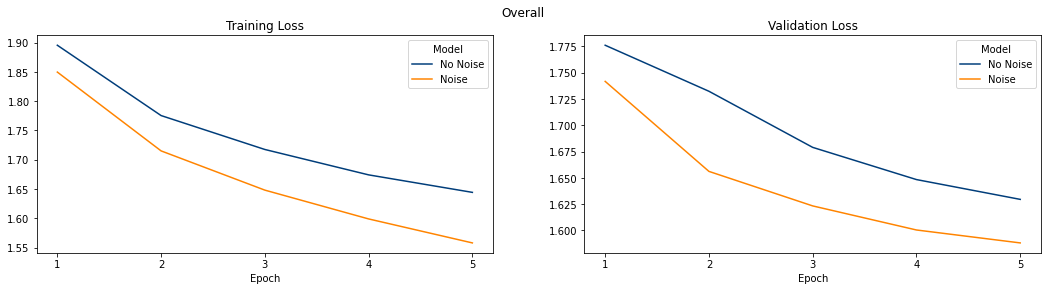

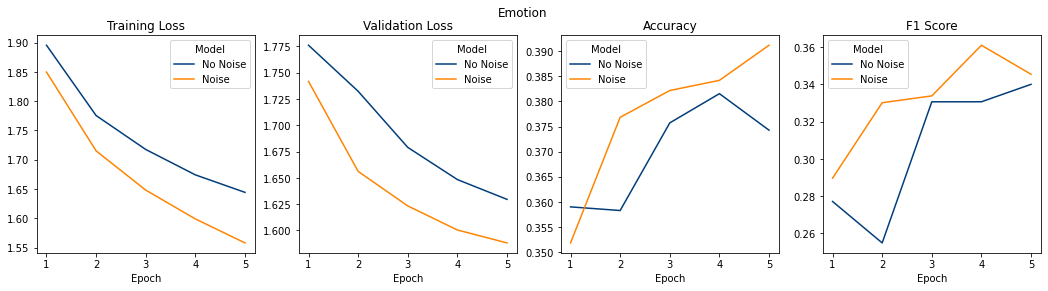

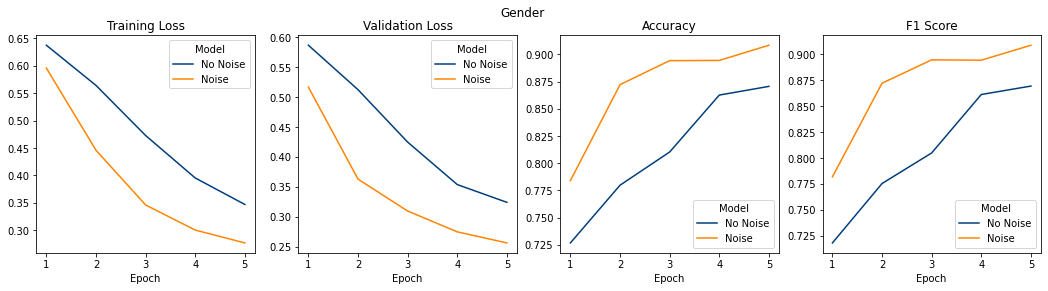

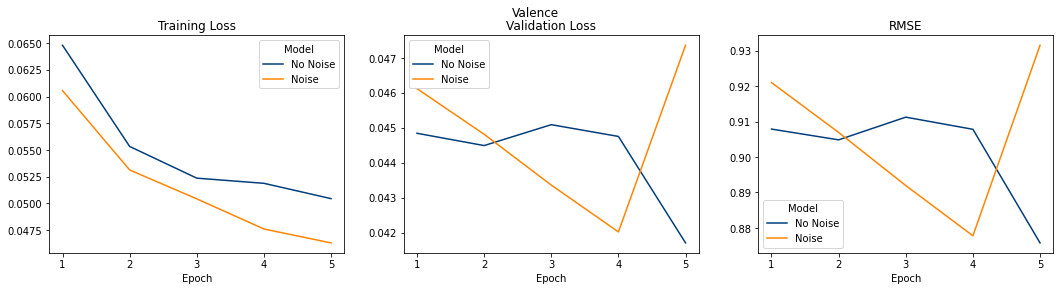

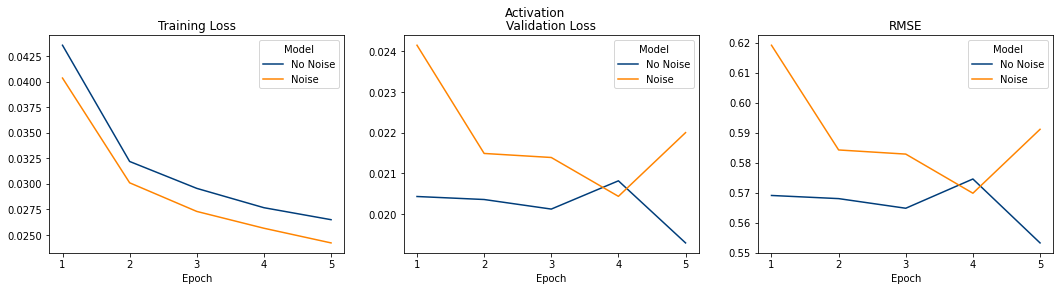

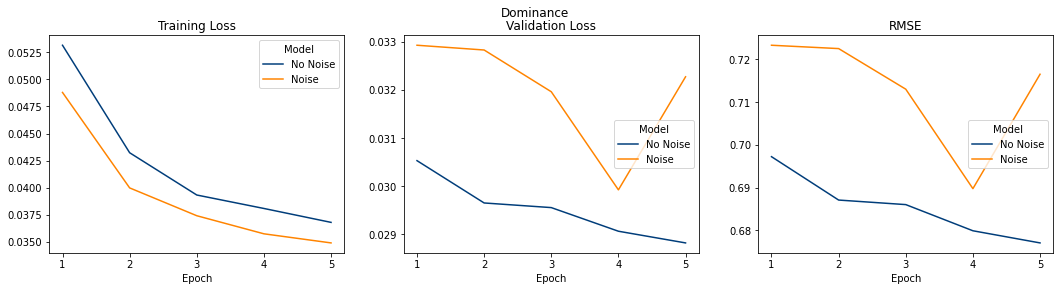

In [ ]:
compare_complex(plotting_data['initial'], 'No Noise', plotting_data['Noise'], 'Noise', epochs = 5)

#### Comparison (Noise and No Noise):

| Category | Overall | Emotion | Gender | Valence | Activation | Dominance |
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| Noise | &#10004; | &#10004; | &#10004; | &#10004; | &#10004; | &#10006; |
| No Noise | &#10006; | &#10006; | &#10006; | &#10006; | &#10006; | &#10004; |

> **Winner** - Noise

#### Time Stretch:
Stretching time by a factor of either **0.75 or 1.25**.
> Valid batches are also modified as different speeds can be expected in real-life scenarios.

In [ ]:
data_batches, shuffled_data = get_batches(batch_size, split_data, ['train', 'valid'], num_augs = [[1, 2, 3], [1, 2, 3]])
batch_data = {'data batches': data_batches, 'shuffled data': shuffled_data, 'batch size': batch_size}
save_data(meta_root, batch_data, 'Batch Data (Dev)')

In [ ]:
model_params = get_complex_model(ARCH, layer_params, transforms, multitask_params, optim_params, task_type)
plotting_data['time'] = train_complex_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 5', layout=Layout(width='500px'), max=5, style=ProgressStyle(des…

Total Epochs = 5
Model Time Shift | Training Duration = 1194.31 sec | Average Duration = 238.86 sec
Model No Time Shift | Training Duration = 806.83 sec | Average Duration = 161.37 sec


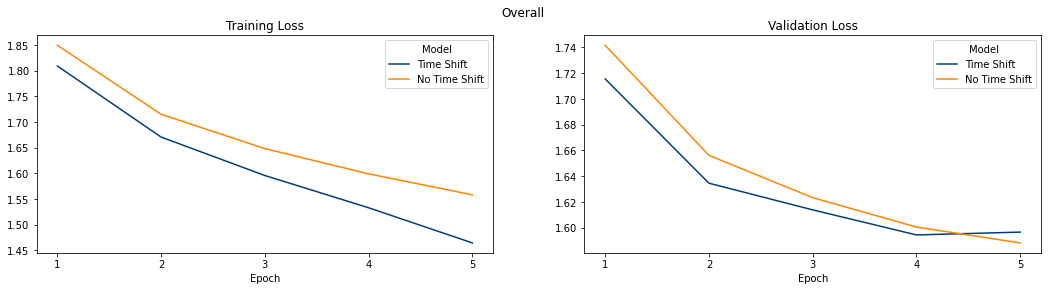

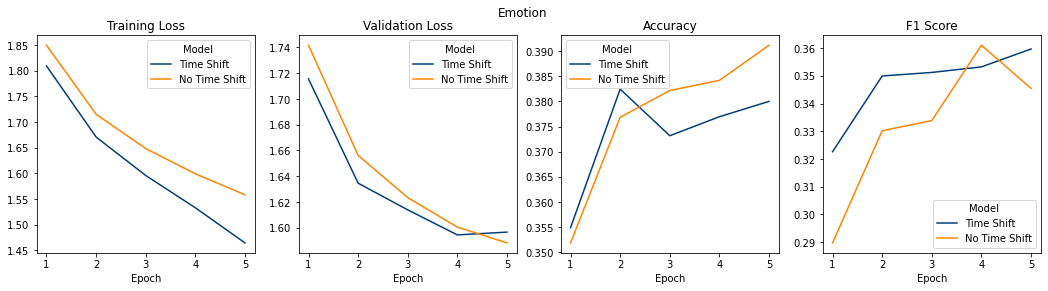

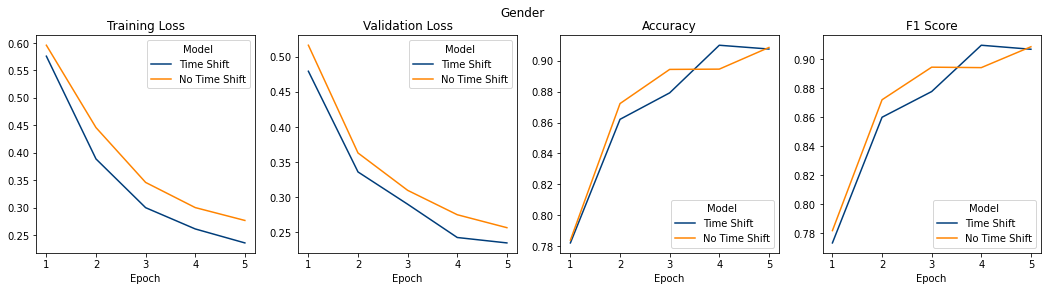

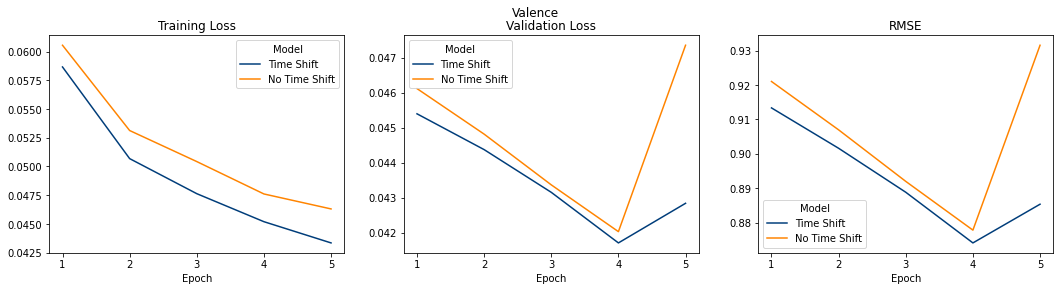

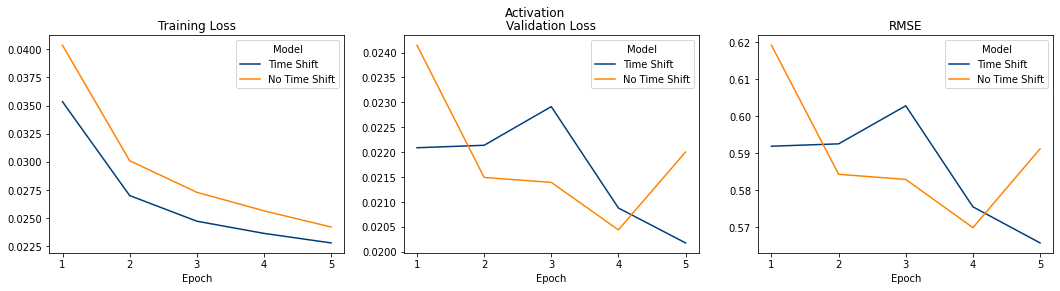

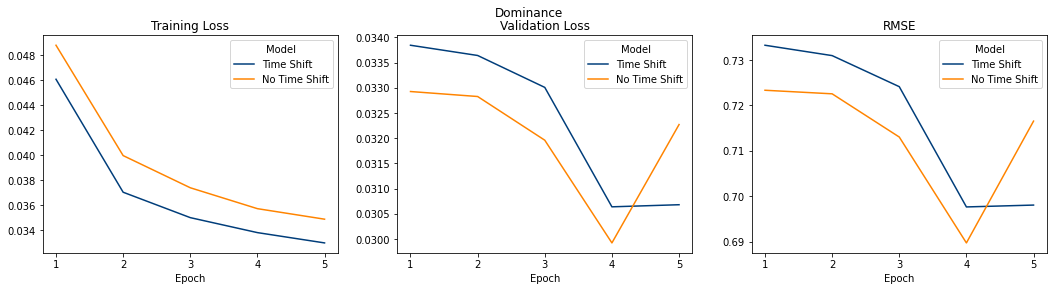

In [ ]:
compare_complex(plotting_data['time'], 'Time Shift', plotting_data['Noise'], 'No Time Shift', epochs = 5)

#### Comparison (Time Shift and No Time Shift):

| Category | Overall | Emotion | Gender | Valence | Activation | Dominance |
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| Time Shift | &#10004; | &#10004; | &#10004; | &#10004; | &#10004; | &#10006; |
| No Time Shift | &#10006; | &#10006; | &#10004; | &#10006; | &#10006; | &#10004; |

> **Winner** - Time Shift

#### Pitch Shift:
Shifting pitch by a factor of either **-1 or 1 semitones**.
> Valid batches are also modified as different pitches can be expected in real-life scenarios.

In [ ]:
data_batches, shuffled_data = get_batches(batch_size, split_data, ['train', 'valid'], num_augs = [[1, 2, 3, 4], [1, 2, 3, 4]])
batch_data = {'data batches': data_batches, 'shuffled data': shuffled_data, 'batch size': batch_size}
save_data(meta_root, batch_data, 'Batch Data (Dev)')

In [ ]:
model_params = get_complex_model(ARCH, layer_params, transforms, multitask_params, optim_params, task_type)
plotting_data['pitch shift'] = train_complex_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 5', layout=Layout(width='500px'), max=5, style=ProgressStyle(des…

Total Epochs = 5
Model No PS | Training Duration = 1544.42 sec | Average Duration = 308.88 sec
Model PS | Training Duration = 1194.31 sec | Average Duration = 238.86 sec


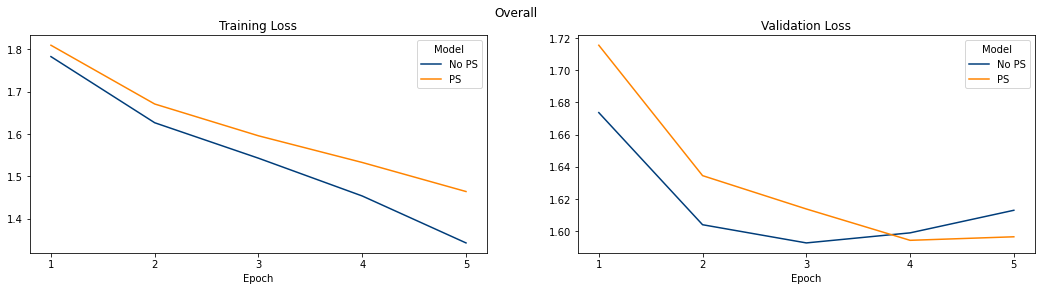

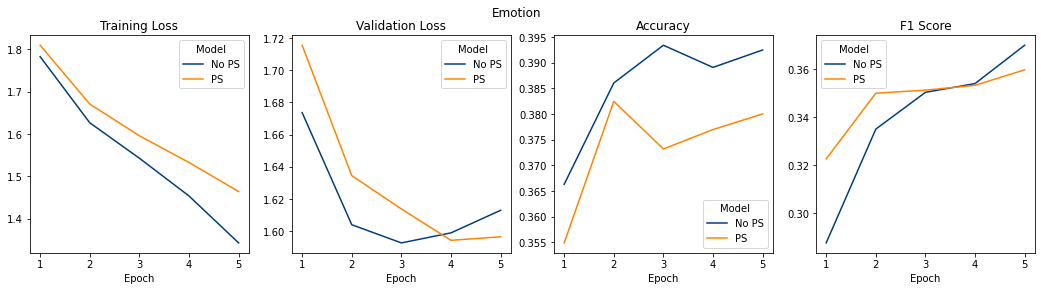

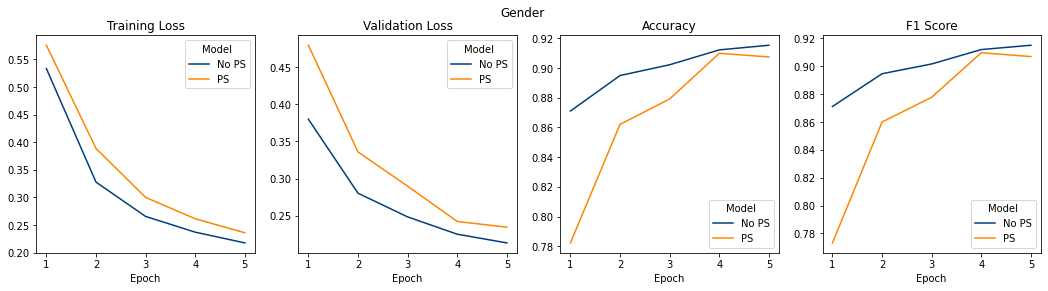

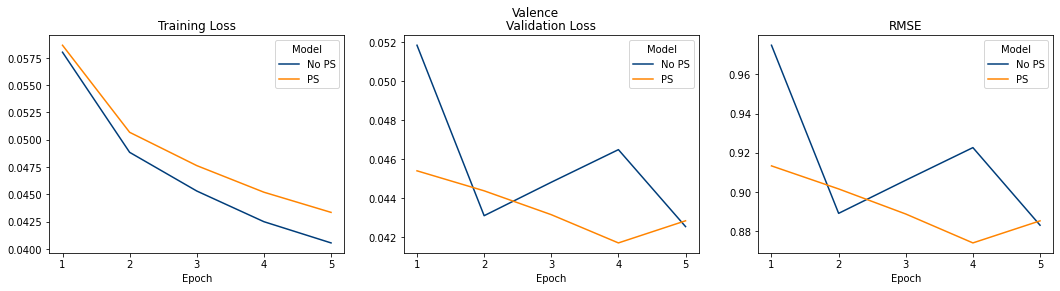

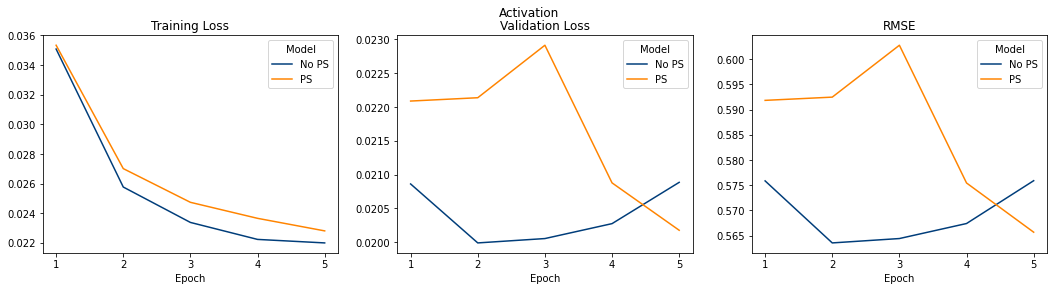

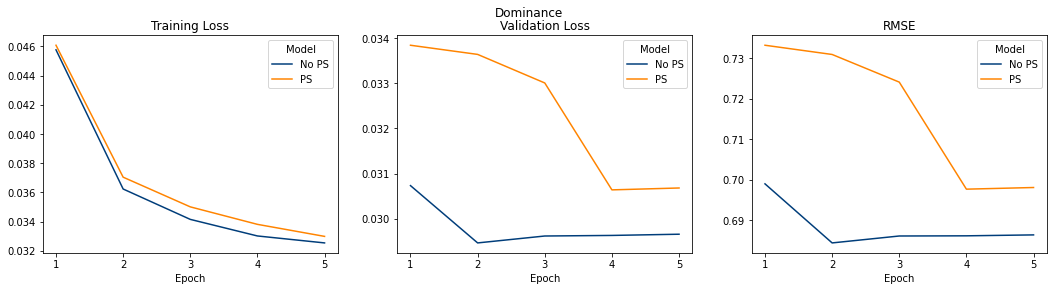

In [ ]:
compare_complex(plotting_data['pitch shift'], 'No PS', plotting_data['time'], 'PS', epochs = 5)

#### Comparison (Pitch Shift and No Pitch Shift):

| Category | Overall | Emotion | Gender | Valence | Activation | Dominance |
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| No Pitch Shift | &#10006; | &#10006; | &#10006; | &#10004; | &#10006; | &#10006; |
| Pitch Shift | &#10004; | &#10004; | &#10004; | &#10006; | &#10004; | &#10004; |

> **Winner** - Pitch Shift.<br>
> **Note** - the legends for the two curves are switched. Thus, Pitch Shift performs better than No Pitch Shift.

#### Frequency Masking:
Masking the frequency channels with mask parameter between **10 and 20**.

> Frequency channels $[f_0, f_0 + f)$ are masked.<br>
> - $f$ is chosen from a uniform distribution from **10** to **20** (the frequency mask parameter $F$).<br>
> - $f_0$ is chosen from $(0, ν − f)$ where $ν$ is the number of frequency channels.

> Valid batches are not modified as it is not expected in real-life scenarios.

In [ ]:
data_batches, shuffled_data = get_batches(batch_size, split_data, ['train', 'valid'], num_augs = [[1, 2, 3, 5], [1, 2, 3]])
batch_data = {'data batches': data_batches, 'shuffled data': shuffled_data, 'batch size': batch_size}
save_data(meta_root, batch_data, 'Batch Data (Dev)')

In [ ]:
model_params = get_complex_model(ARCH, layer_params, transforms, multitask_params, optim_params, task_type)
plotting_data['freq mask'] = train_complex_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 5', layout=Layout(width='500px'), max=5, style=ProgressStyle(des…

Total Epochs = 5
Model Freq Mask | Training Duration = 1525.52 sec | Average Duration = 305.10 sec
Model No Mask | Training Duration = 1194.31 sec | Average Duration = 238.86 sec


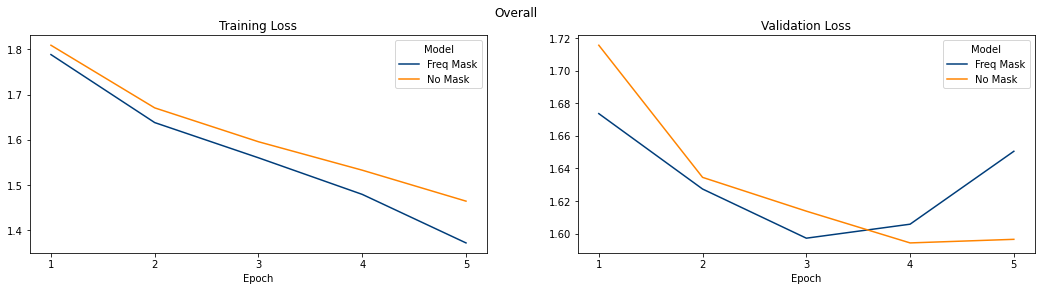

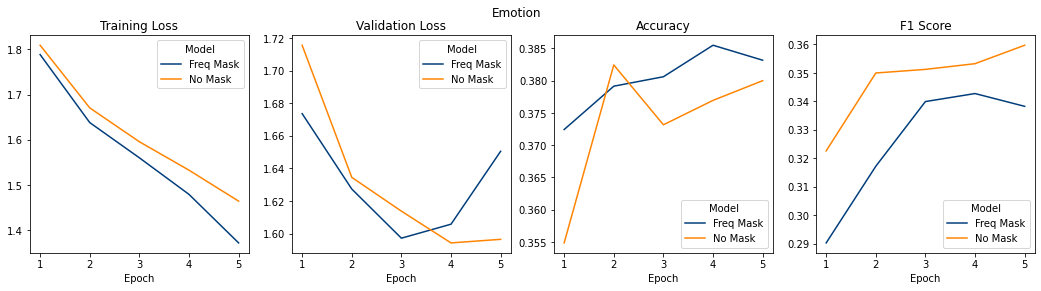

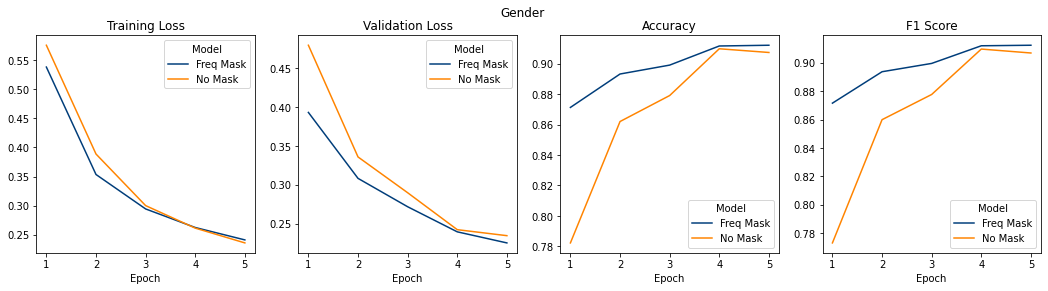

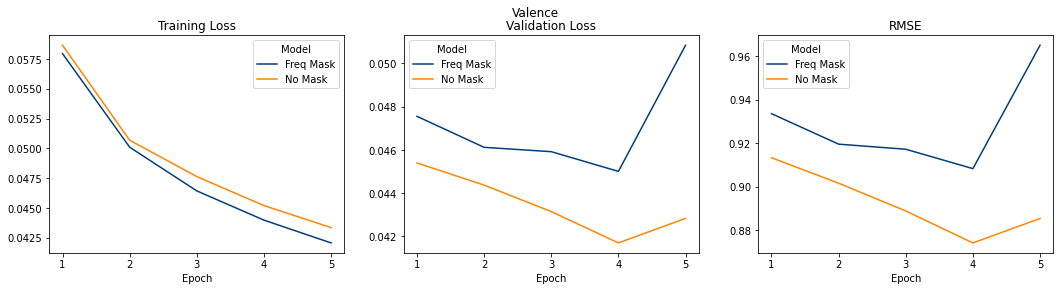

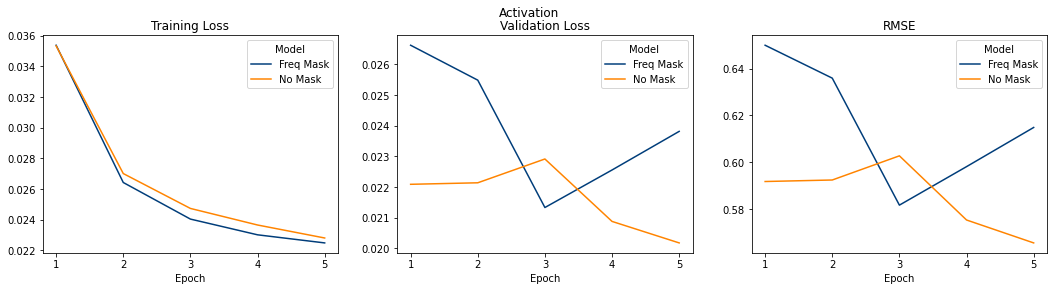

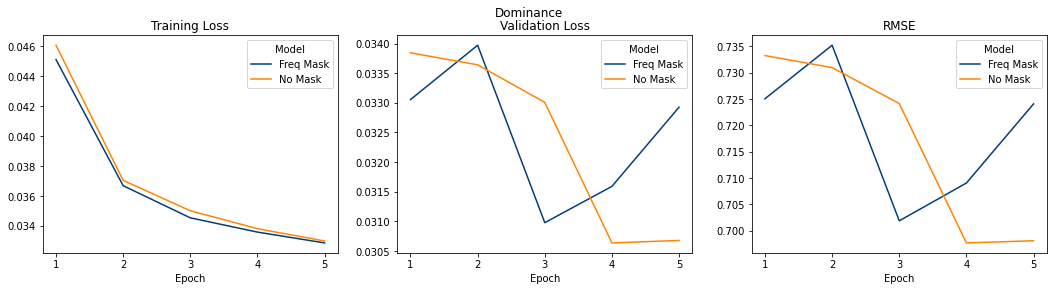

In [ ]:
compare_complex(plotting_data['freq mask'], 'Freq Mask', plotting_data['time'], 'No Mask', epochs = 5)

#### Comparison (Freq Mask and No Freq Mask):

| Category | Overall | Emotion | Gender | Valence | Activation | Dominance |
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| Freq Mask | &#10004; | &#10006; | &#10004; | &#10006; | &#10004; | &#10004; |
| No Freq Mask | &#10006; | &#10004; | &#10006; | &#10004; | &#10006; | &#10006; |

> **Winner** - Freq Mask

#### Time Masking:
Masking the time steps with mask parameter between **10 and 20**.

> t consecutive time steps $[t_0, t_0 + t)$ are masked.<br>
> - $t$ is chosen from a uniform distribution from **10** to **20** (the frequency mask parameter $T$).<br>
> - $t_0$ is chosen from $(0, \tau − t)$ where $\tau$ is the time steps.

> Valid batches are not modified as it is not expected in real-life scenarios.

In [ ]:
data_batches, shuffled_data = get_batches(batch_size, split_data, ['train', 'valid'], num_augs = [[1, 2, 3, 5, 6], [1, 2, 3]])
batch_data = {'data batches': data_batches, 'shuffled data': shuffled_data, 'batch size': batch_size}
save_data(meta_root, batch_data, 'Batch Data (Dev)')

In [ ]:
model_params = get_complex_model(ARCH, layer_params, transforms, multitask_params, optim_params, task_type)
plotting_data['time mask'] = train_complex_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 5', layout=Layout(width='500px'), max=5, style=ProgressStyle(des…

Total Epochs = 5
Model Time Mask | Training Duration = 1866.37 sec | Average Duration = 373.27 sec
Model No Time Mask | Training Duration = 1525.52 sec | Average Duration = 305.10 sec


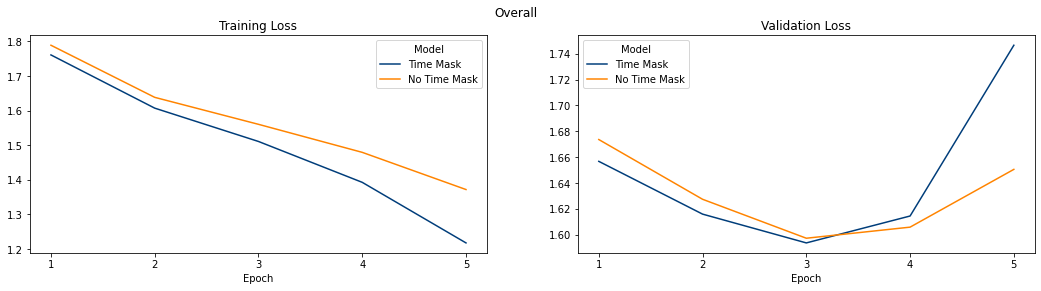

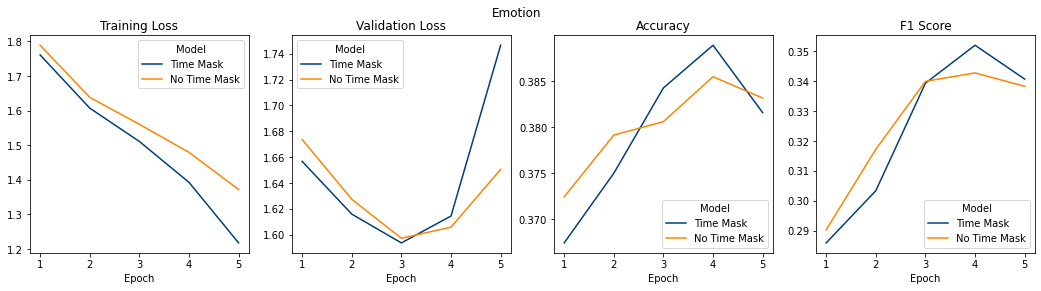

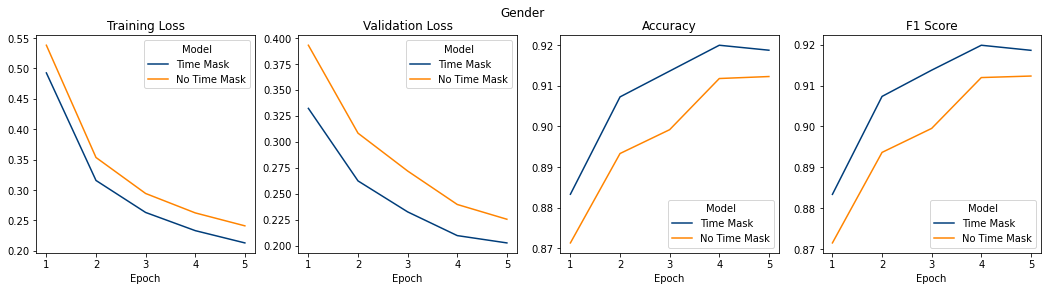

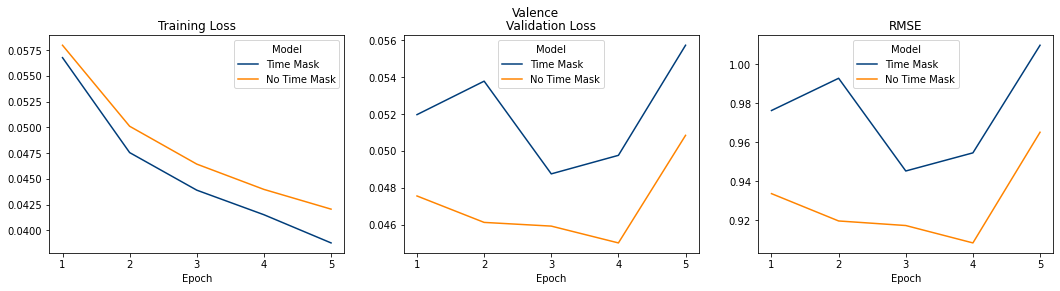

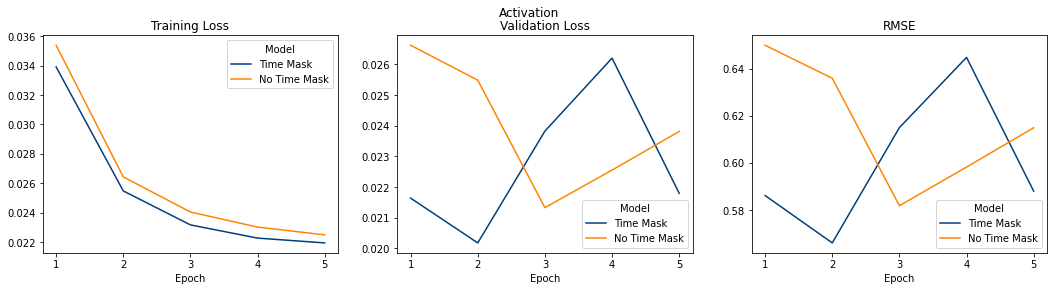

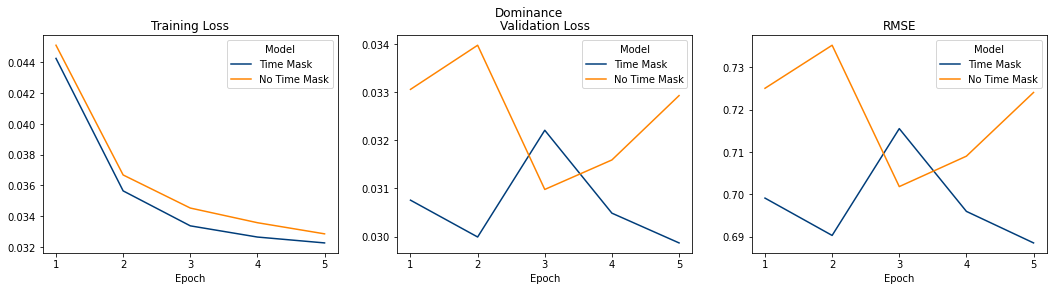

In [ ]:
compare_complex(plotting_data['time mask'], 'Time Mask', plotting_data['freq mask'], 'No Time Mask', epochs = 5)

#### Comparison (Time Mask and No Time Mask):

| Category | Overall | Emotion | Gender | Valence | Activation | Dominance |
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| Time Mask | &#10004; | &#10004; | &#10004; | &#10006; | &#10004; | &#10004; |
| No Time Mask | &#10006; | &#10006; | &#10006; | &#10004; | &#10006; | &#10006; |

> **Winner** - Time Mask

<a id='section_two'></a>
## Section II
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

In this section, following hyperparameters are examined -
- Batch size.
- Dropout.
- Attention parameter.
- Task layers.
- Weight decay.
- Learning rate decay.

> `num_augs` - which augmentations to include. Only unaugmented samples are considered.<br>
> `epochs` - training for **5**.

In [ ]:
other_params['epochs'] = 5

data_batches, shuffled_data = get_batches(batch_size, split_data, ['train', 'valid'], num_augs = [[1, 2, 3, 5, 6], [1, 2, 3]])
batch_data = {'data batches': data_batches, 'shuffled data': shuffled_data, 'batch size': batch_size}
save_data(meta_root, batch_data, 'Batch Data (Dev)')

#### Batch Size:
> `batch_size` - set to **32**.

In [ ]:
other_params['batch size'] = 32

In [ ]:
model_params = get_complex_model(ARCH, layer_params, transforms, multitask_params, optim_params, task_type)
plotting_data['bs 32'] = train_complex_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 5', layout=Layout(width='500px'), max=5, style=ProgressStyle(des…

Total Epochs = 5
Model BS 64 | Training Duration = 1866.37 sec | Average Duration = 373.27 sec
Model BS 32 | Training Duration = 1828.69 sec | Average Duration = 365.74 sec


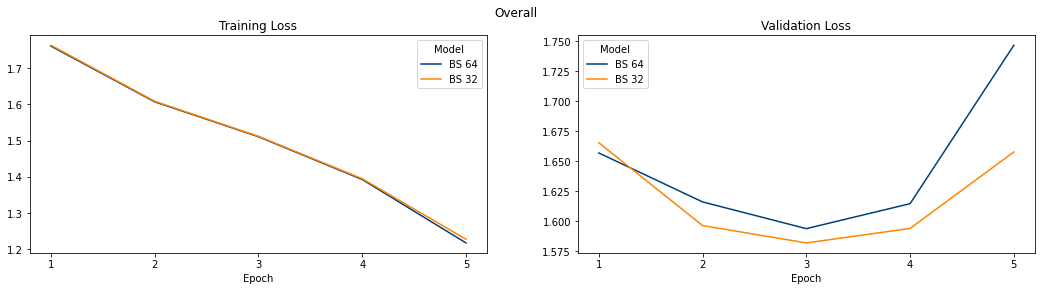

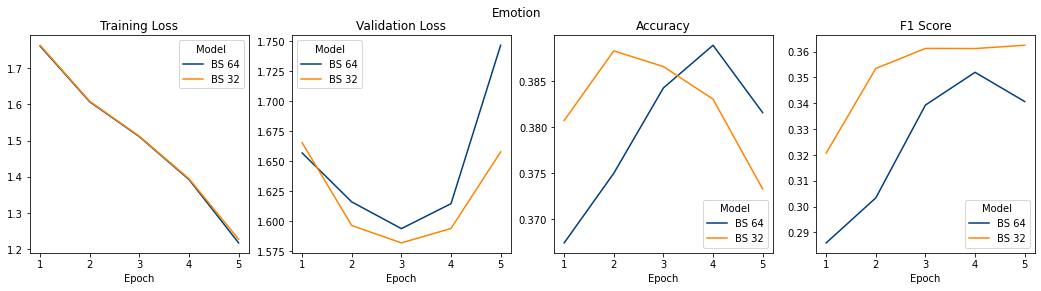

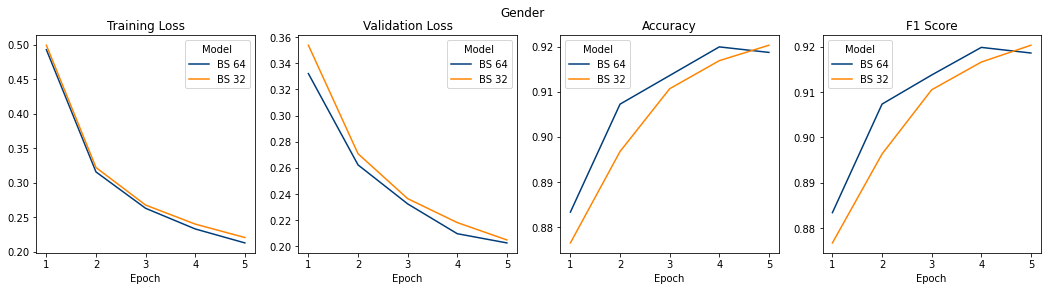

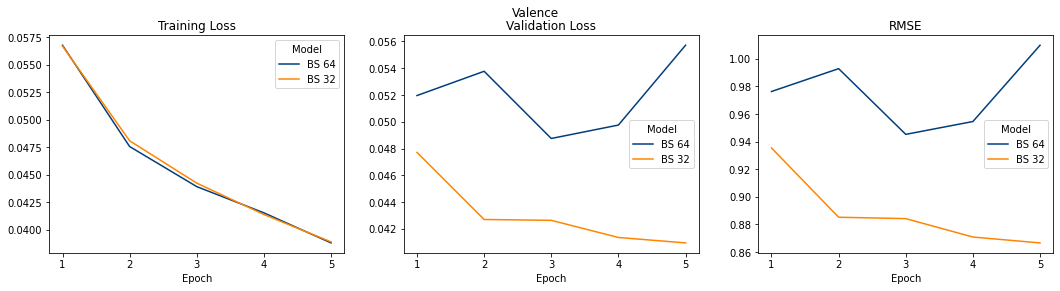

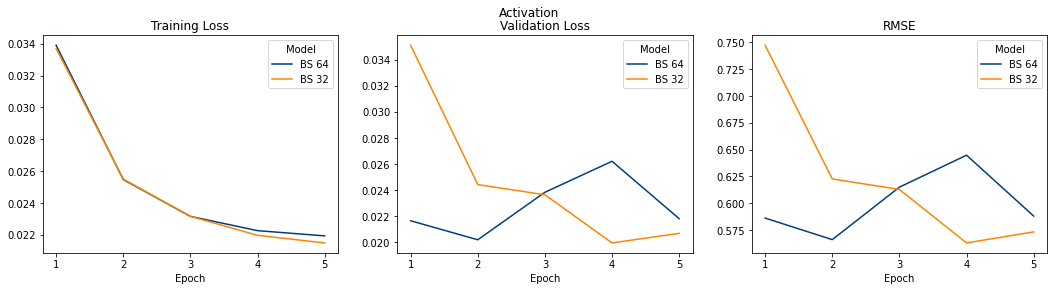

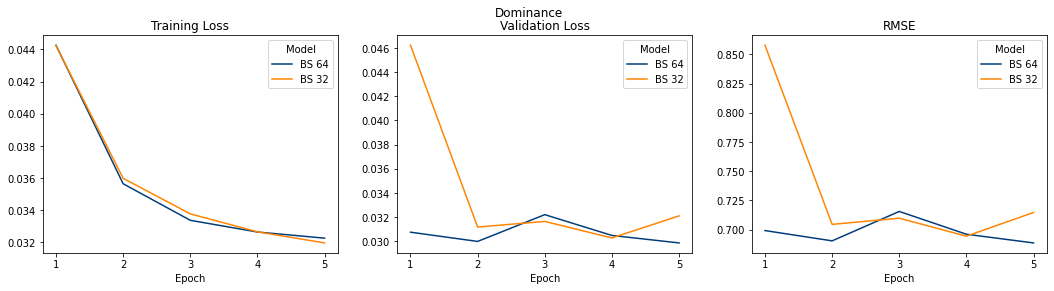

In [ ]:
compare_complex(plotting_data['time mask'], 'BS 64', plotting_data['bs 32'], 'BS 32', epochs = 5)

#### Comparison (BS 32 and BS 64):

| Category | Overall | Emotion | Gender | Valence | Activation | Dominance |
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| BS 32 | &#10004; | &#10006; | &#10004; | &#10004; | &#10004; | &#10004; |
| BS 64 | &#10006; | &#10004; | &#10006; | &#10006; | &#10006; | &#10004; |

> **Winner** - BS 32

In [ ]:
other_params['batch size'] = 32

#### Dropout:
> `dropout` - set to **0.8**.

In [ ]:
layer_params = {
    'activation': 'relu', 'pooling': 'max', 'dropout': 0.8, 'batch norm': False, 
    'attention': 0.0001, 'weight init': False
               }

model_params = get_complex_model(ARCH, layer_params, transforms, multitask_params, optim_params, task_type)
plotting_data['dropout 0.8'] = train_complex_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 5', layout=Layout(width='500px'), max=5, style=ProgressStyle(des…

Total Epochs = 5
Model Dropout 0.8 | Training Duration = 1820.88 sec | Average Duration = 364.18 sec
Model Dropout 0.5 | Training Duration = 1828.69 sec | Average Duration = 365.74 sec


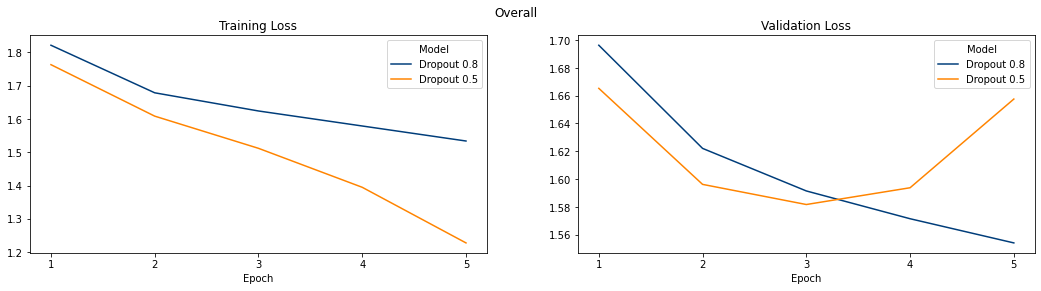

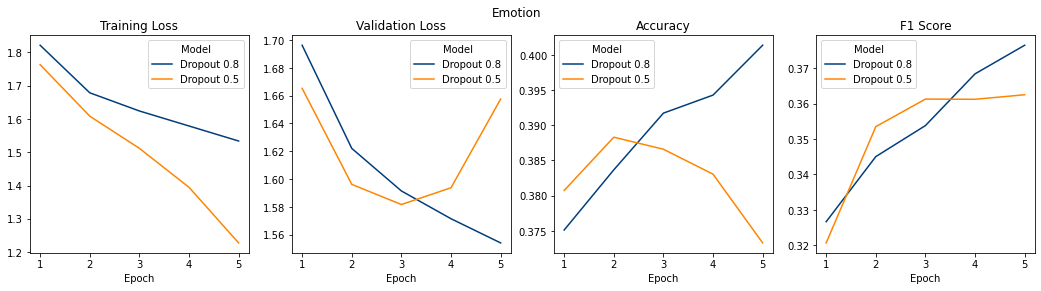

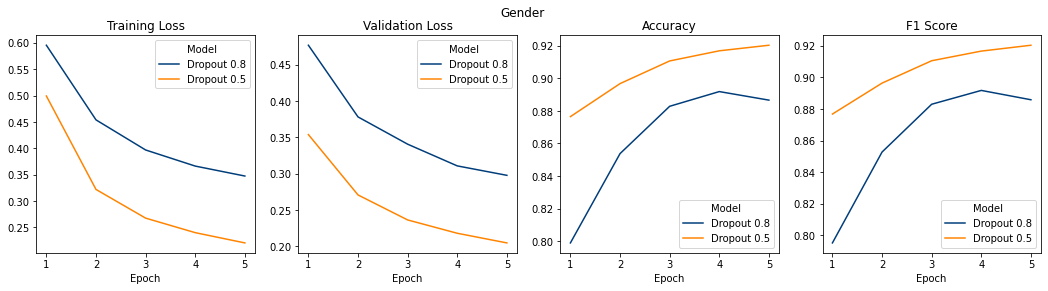

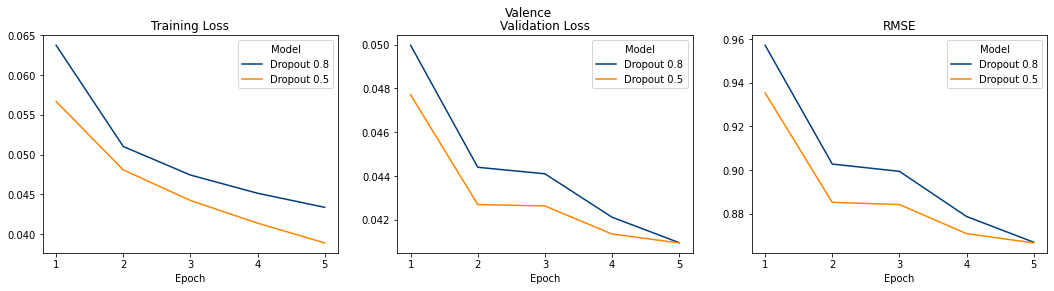

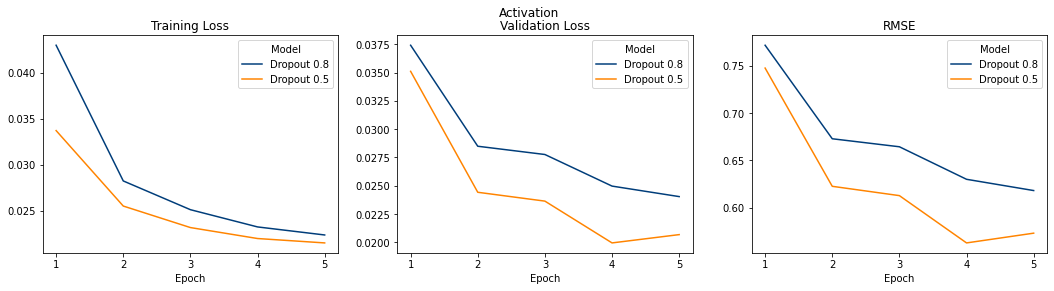

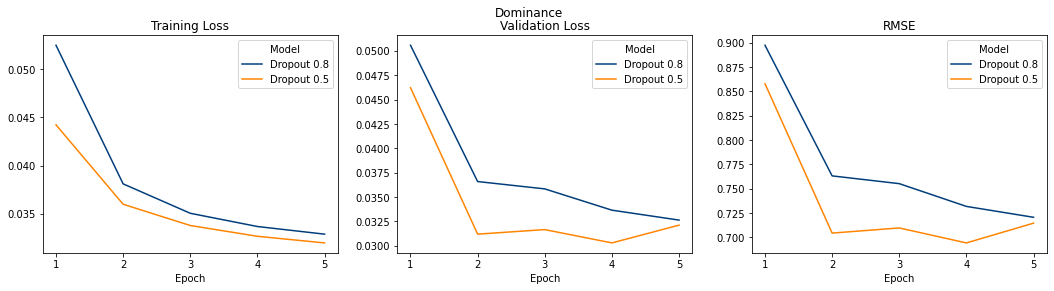

In [ ]:
compare_complex(plotting_data['dropout 0.8'], 'Dropout 0.8', plotting_data['bs 32'], 'Dropout 0.5', epochs = 5)

#### Comparison (0.5 and 0.8):

| Category | Overall | Emotion | Gender | Valence | Activation | Dominance |
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| 0.5 | &#10006; | &#10006; | &#10004; | &#10004; | &#10004; | &#10004; |
| 0.8 | &#10004; | &#10004; | &#10006; | &#10004; | &#10006; | &#10006; |

> **Winner** - 0.8

#### Attention Parameter -
> `attention` - **0.001**.

In [ ]:
layer_params = {
    'activation': 'relu', 'pooling': 'max', 'dropout': 0.8, 'batch norm': False, 
    'attention': 0.001, 'weight init': False
               }

model_params = get_complex_model(ARCH, layer_params, transforms, multitask_params, optim_params, task_type)
plotting_data['attention 0.001'] = train_complex_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 5', layout=Layout(width='500px'), max=5, style=ProgressStyle(des…

Total Epochs = 5
Model 0.001 | Training Duration = 1845.95 sec | Average Duration = 369.19 sec
Model 0.0001 | Training Duration = 1820.88 sec | Average Duration = 364.18 sec


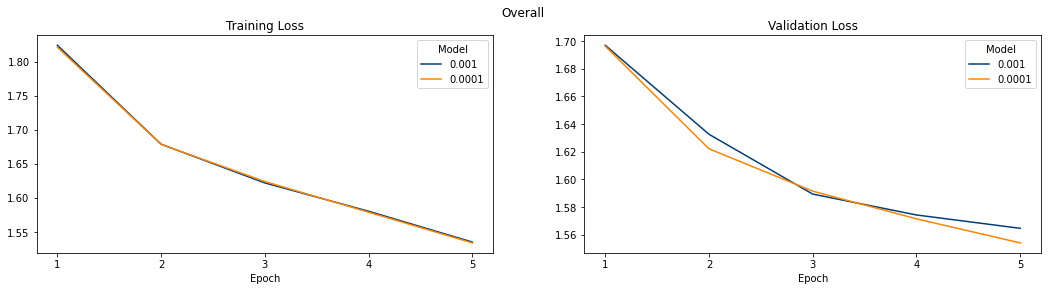

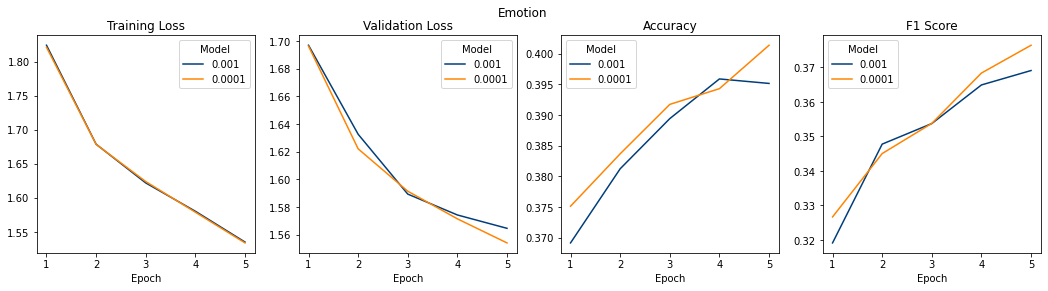

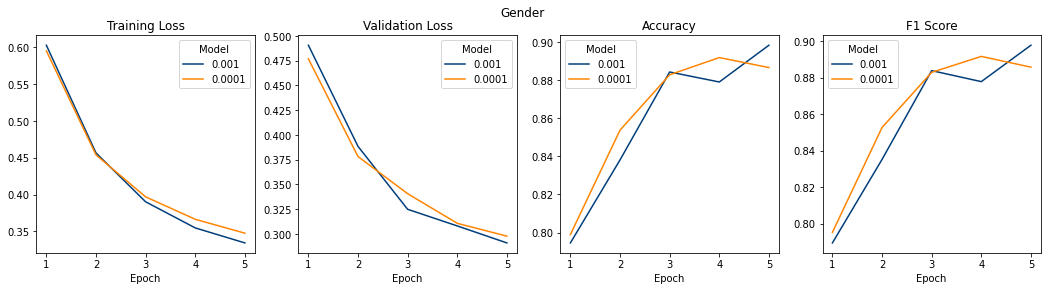

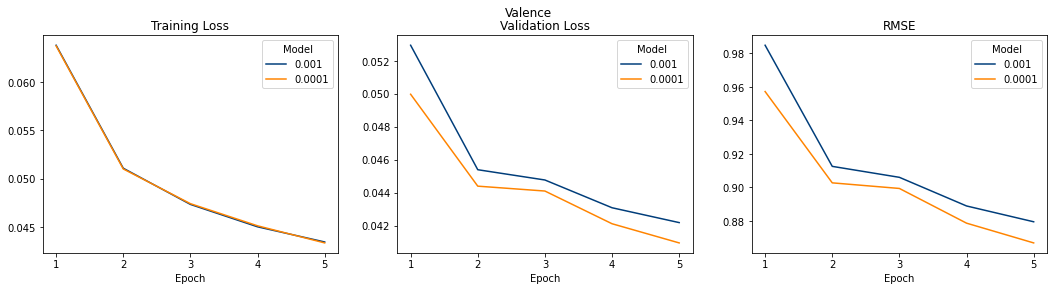

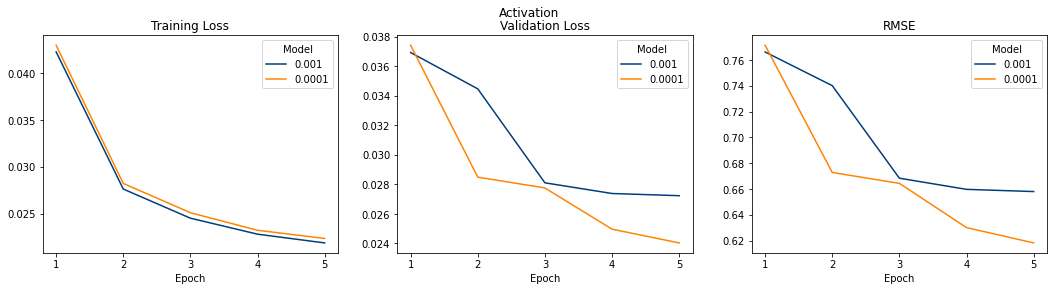

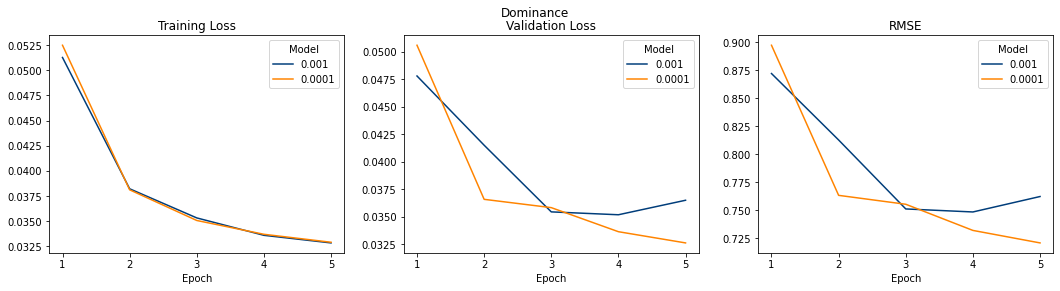

In [ ]:
compare_complex(plotting_data['attention 0.001'], '0.001', plotting_data['dropout 0.8'], '0.0001', epochs = 5)

#### Comparison (0.001 and 0.0001):

| Category | Overall | Emotion | Gender | Valence | Activation | Dominance |
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| 0.001 | &#10006; | &#10006; | &#10004; | &#10004; | &#10006; | &#10006; |
| 0.0001 | &#10004; | &#10004; | &#10004; | &#10004; | &#10004; | &#10004; |

> **Winner** - 0.0001

In [14]:
layer_params = {
    'activation': 'relu', 'pooling': 'max', 'dropout': 0.8, 'batch norm': False, 
    'attention': 0.0001, 'weight init': False
               }

#### Task Layers:
The size of task-specific layers are -
- Emotion - 1024 
- Gender - 128
- Valence - 128
- Activation - 128
- Dominance - 128

In [ ]:
task_layers = [1024, 128, 128, 128, 128]
multitask_params = {'loss type': 'weighted param', 'loss weights': None, 'task layers': task_layers}

model_params = get_complex_model(ARCH, layer_params, transforms, multitask_params, optim_params, task_type)
plotting_data['task specific'] = train_complex_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 5', layout=Layout(width='500px'), max=5, style=ProgressStyle(des…

Total Epochs = 5
Model TS | Training Duration = 2166.94 sec | Average Duration = 433.39 sec
Model No TS | Training Duration = 1820.88 sec | Average Duration = 364.18 sec


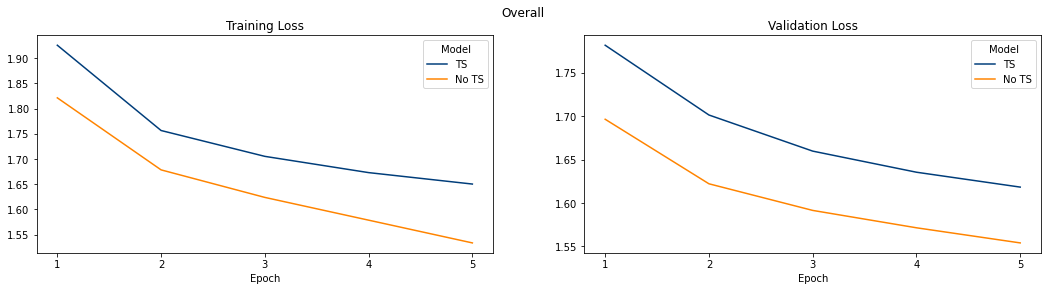

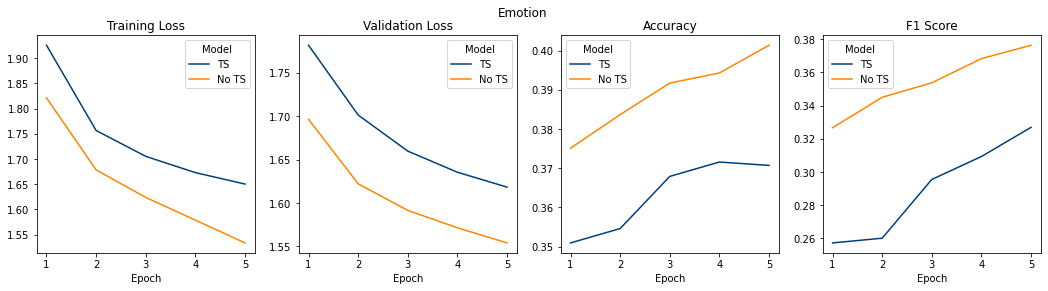

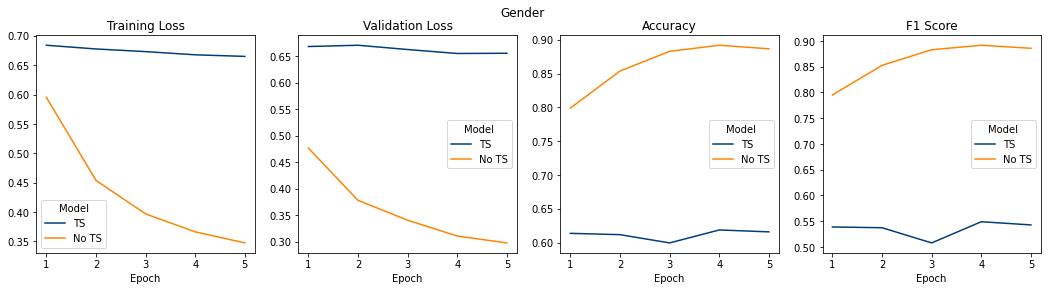

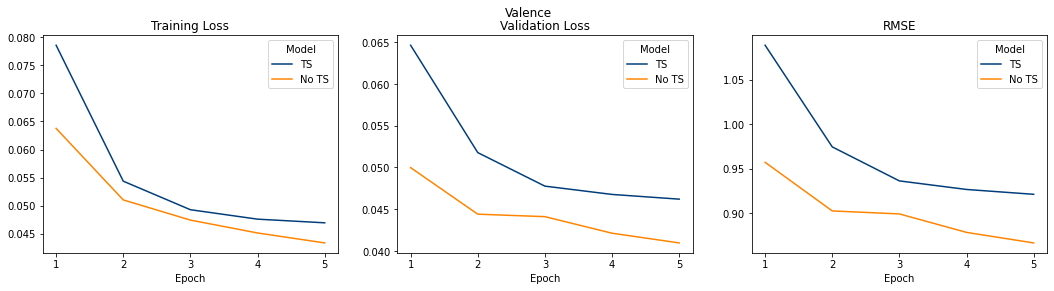

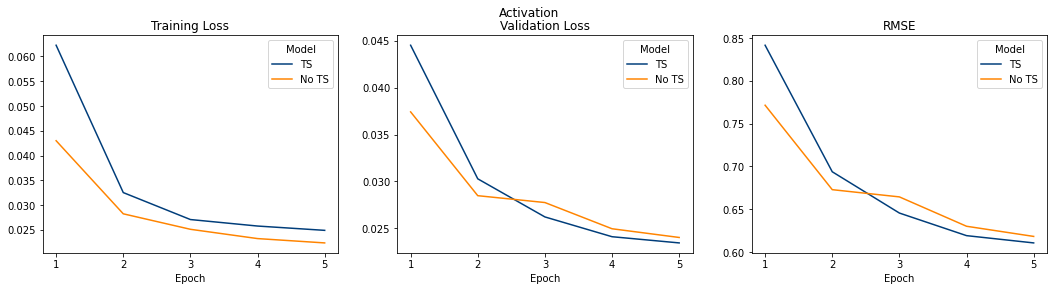

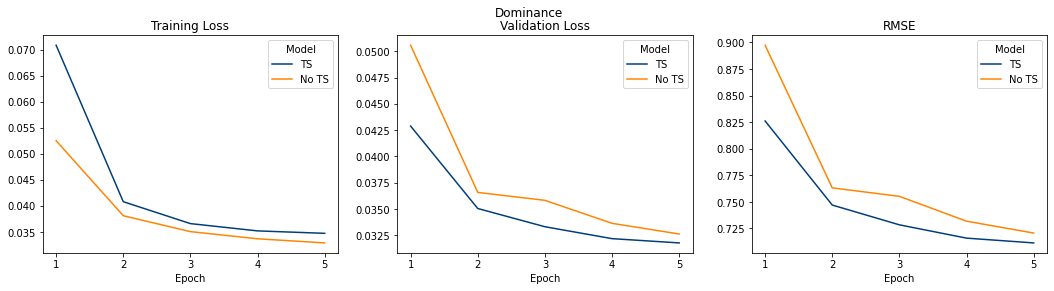

In [ ]:
compare_complex(plotting_data['task specific'], 'TS', plotting_data['dropout 0.8'], 'No TS', epochs = 5)

#### Comparison (TS and No TS):

| Category | Overall | Emotion | Gender | Valence | Activation | Dominance |
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| TS | &#10006; | &#10006; | &#10006; | &#10006; | &#10004; | &#10004; |
| No TS | &#10004; | &#10004; | &#10004; | &#10004; | &#10006; | &#10006; |

> **Winner** - No TS

In [15]:
multitask_params = {'loss type': 'weighted param', 'loss weights': None, 'task layers': None}

#### Weight Decay-
> `weight decay` - set to **0.001**.

In [18]:
optim_params = {'learning rate': 0.01, 'type': 'sgd', 'momentum': 0, 'weight decay': 0.001, 'scheduler': scheduler_param}

model_params = get_complex_model(ARCH, layer_params, transforms, multitask_params, optim_params, task_type)
plotting_data['weight decay'] = train_complex_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 5', layout=Layout(width='500px'), max=5, style=ProgressStyle(des…

Total Epochs = 5
Model WD | Training Duration = 1682.12 sec | Average Duration = 336.42 sec
Model No WD | Training Duration = 1820.88 sec | Average Duration = 364.18 sec


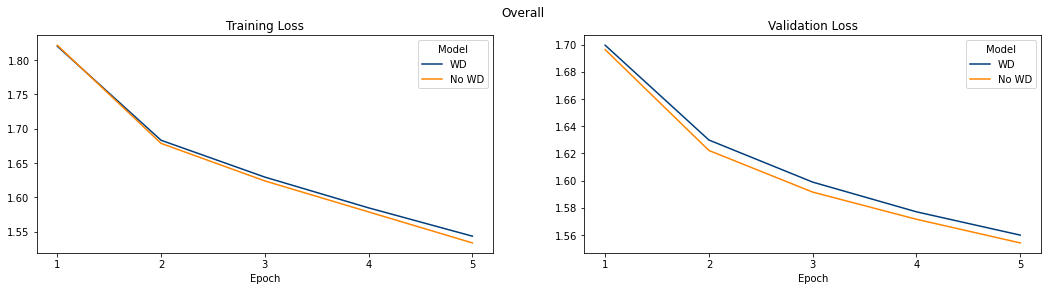

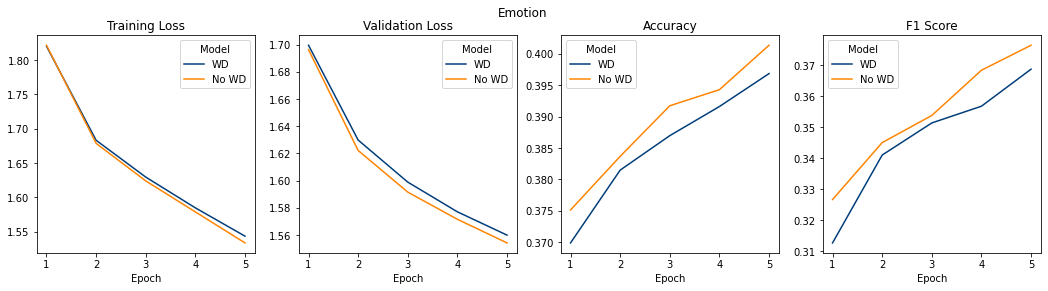

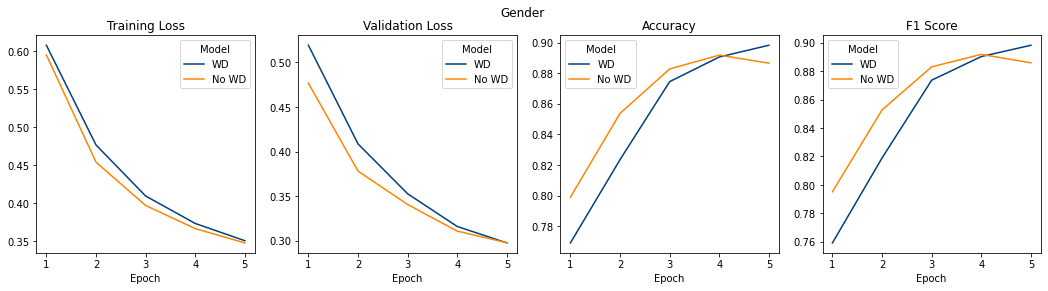

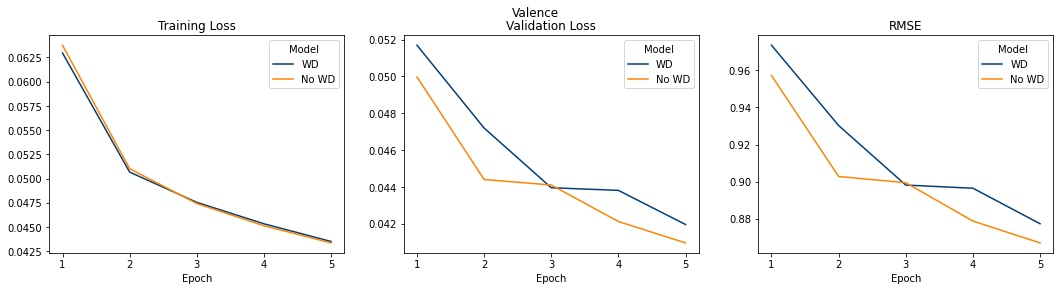

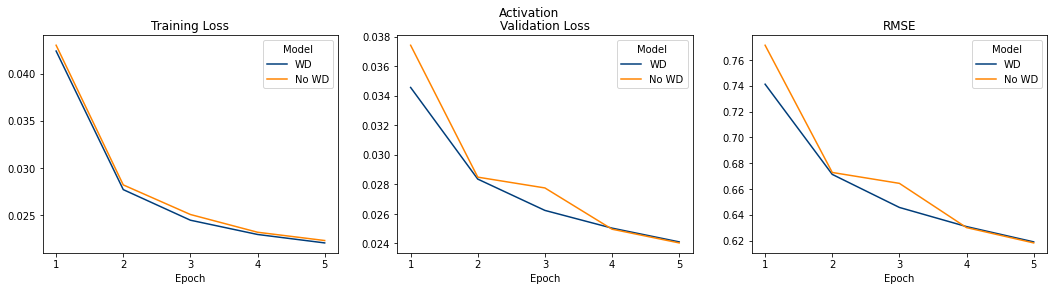

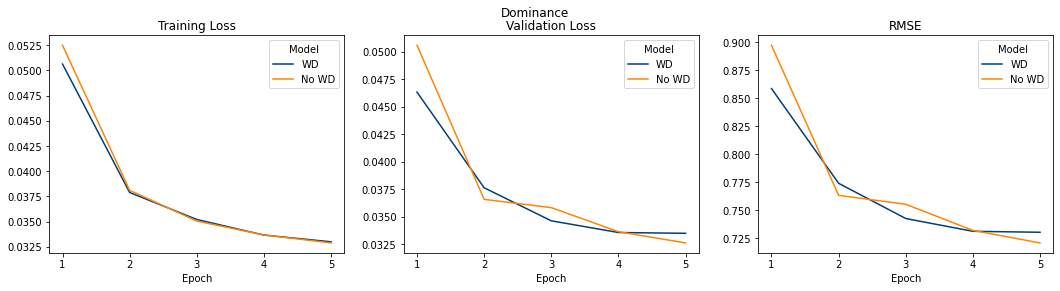

In [19]:
compare_complex(plotting_data['weight decay'], 'WD', plotting_data['dropout 0.8'], 'No WD', epochs = 5)

#### Comparison (WD and No WD):

| Category | Overall | Emotion | Gender | Valence | Activation | Dominance |
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| WD | &#10004; | &#10006; | &#10004; | &#10004; | &#10004; | &#10004; |
| No WD | &#10004; | &#10004; | &#10006; | &#10004; | &#10004; | &#10004; |

> **Winner** - No WD

#### Learning Rate Decay:
> `milestones` - set to **10**.<br>
> `gamma` - set to **0.5**.

In [21]:
data_batches, shuffled_data = get_batches(batch_size, split_data, ['train', 'valid'], num_augs = [[1], [1]])
batch_data = {'data batches': data_batches, 'shuffled data': shuffled_data, 'batch size': batch_size}
save_data(meta_root, batch_data, 'Batch Data (Dev)')

other_params['epochs'] = 30

In [22]:
scheduler_param = ([10], 0.5)
optim_params = {'learning rate': 0.01, 'type': 'sgd', 'momentum': 0, 'weight decay': 0, 'scheduler': scheduler_param}

model_params = get_complex_model(ARCH, layer_params, transforms, multitask_params, optim_params, task_type)
plotting_data['gamma 0.5'] = train_complex_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 30', layout=Layout(width='500px'), max=30, style=ProgressStyle(d…

In [23]:
scheduler_param = ([10], 0.1)
optim_params = {'learning rate': 0.01, 'type': 'sgd', 'momentum': 0, 'weight decay': 0, 'scheduler': scheduler_param}

model_params = get_complex_model(ARCH, layer_params, transforms, multitask_params, optim_params, task_type)
plotting_data['gamma 0.1'] = train_complex_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 30', layout=Layout(width='500px'), max=30, style=ProgressStyle(d…

In [31]:
scheduler_param = ([10], 0.8)
optim_params = {'learning rate': 0.01, 'type': 'sgd', 'momentum': 0, 'weight decay': 0, 'scheduler': scheduler_param}

model_params = get_complex_model(ARCH, layer_params, transforms, multitask_params, optim_params, task_type)
plotting_data['gamma 0.8'] = train_complex_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 30', layout=Layout(width='500px'), max=30, style=ProgressStyle(d…

Total Epochs = 30
Model 0.5 | Training Duration = 1742.32 sec | Average Duration = 58.08 sec
Model 0.1 | Training Duration = 1734.20 sec | Average Duration = 57.81 sec


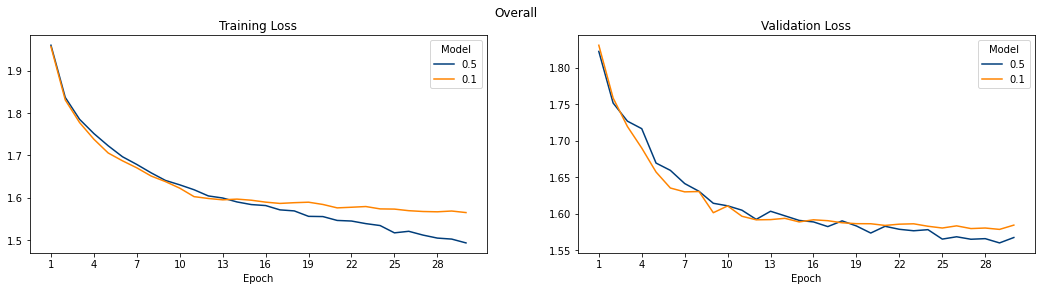

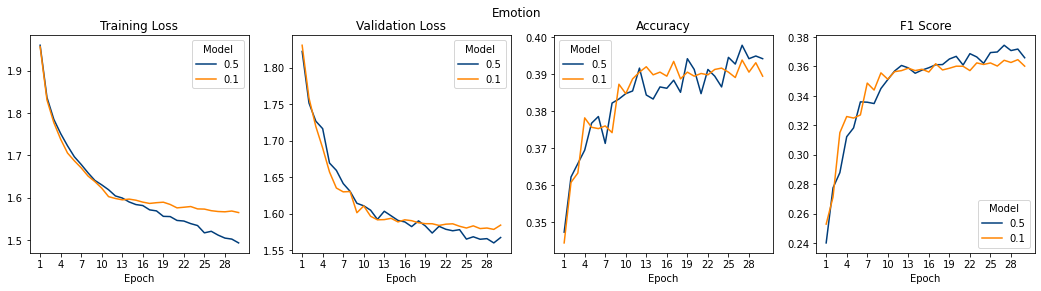

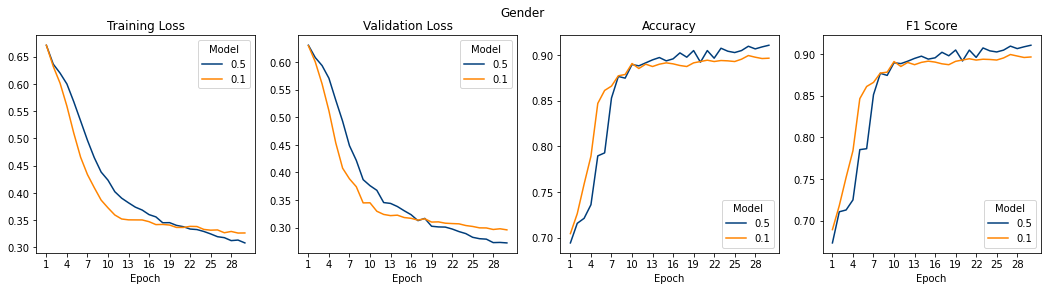

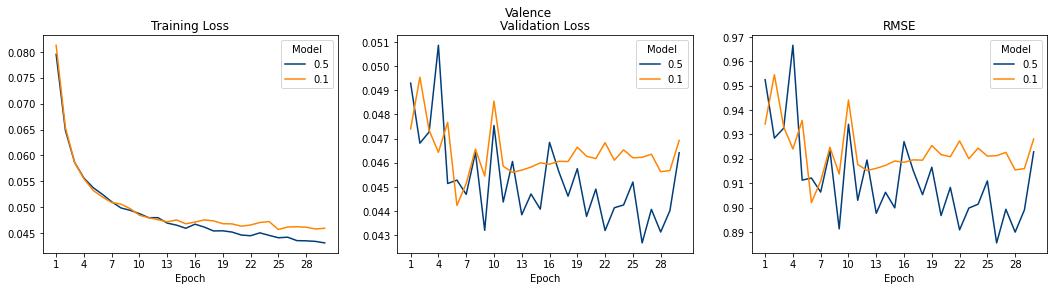

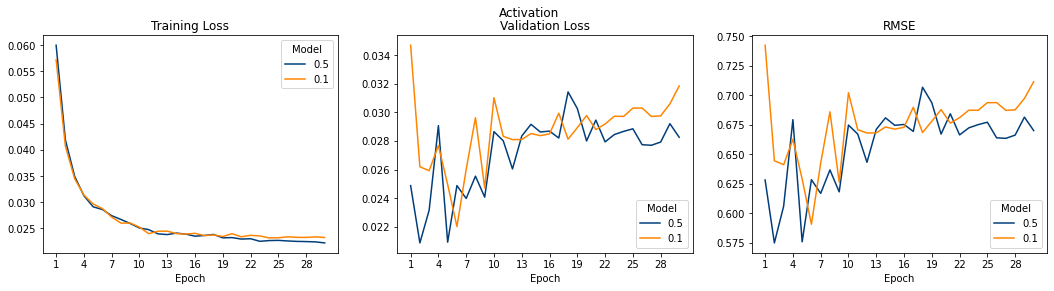

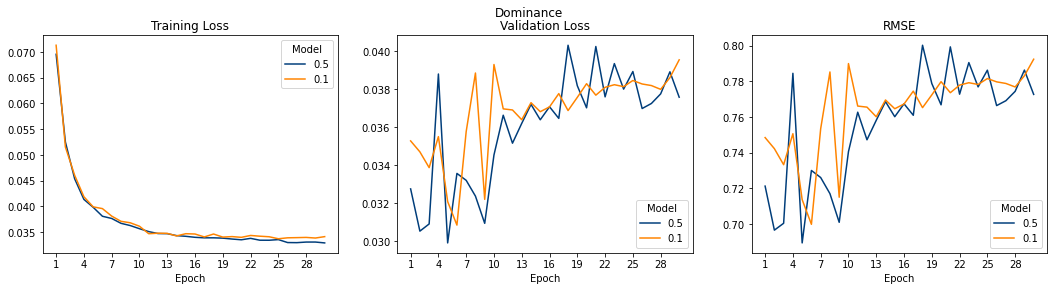

In [30]:
compare_complex(plotting_data['gamma 0.5'], '0.5', plotting_data['gamma 0.1'], '0.1', epochs = 30, x_jump = 3)

#### Comparison (0.5 and 0.1):

| Category | Overall | Emotion | Gender | Valence | Activation | Dominance |
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| 0.5 | &#10004; | &#10004; | &#10004; | &#10004; | &#10004; | &#10004; |
| 0.1 | &#10004; | &#10004; | &#10004; | &#10006; | &#10004; | &#10004; |

> **Winner** - 0.5

Total Epochs = 30
Model 0.5 | Training Duration = 1742.32 sec | Average Duration = 58.08 sec
Model 0.8 | Training Duration = 1738.10 sec | Average Duration = 57.94 sec


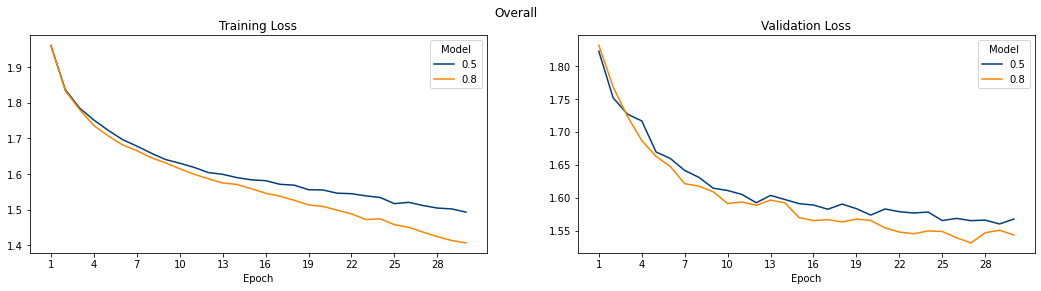

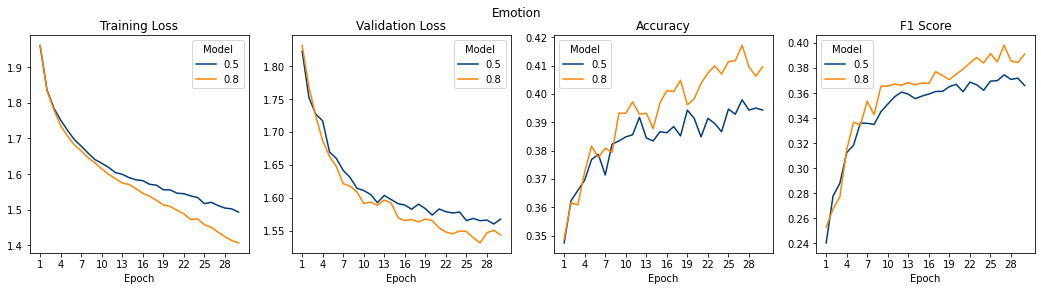

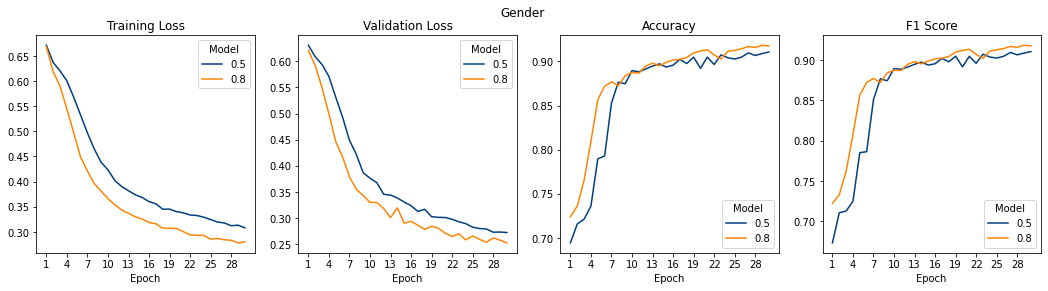

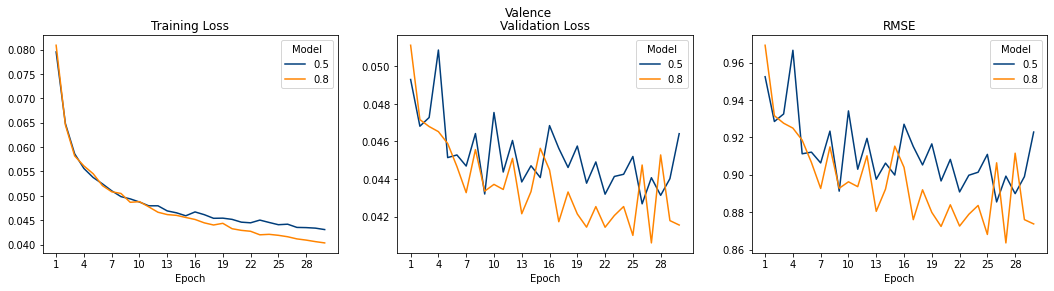

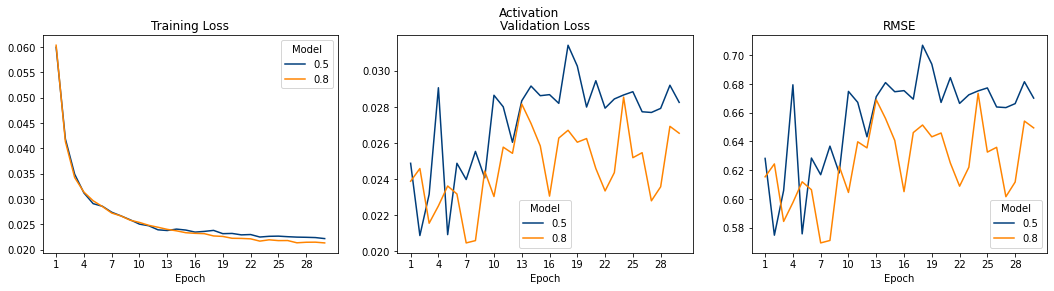

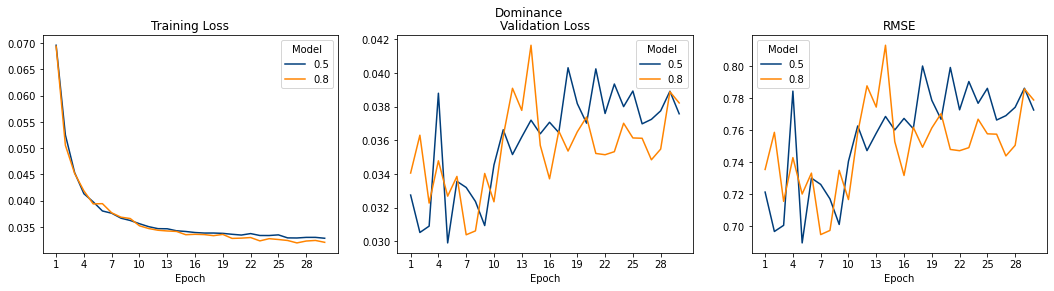

In [32]:
compare_complex(plotting_data['gamma 0.5'], '0.5', plotting_data['gamma 0.8'], '0.8', epochs = 30, x_jump = 3)

#### Comparison (0.5 and 0.8):

| Category | Overall | Emotion | Gender | Valence | Activation | Dominance |
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| 0.5 | &#10006; | &#10006; | &#10004; | &#10006; | &#10006; | &#10004; |
| 0.8 | &#10004; | &#10004; | &#10004; | &#10004; | &#10004; | &#10004; |

> **Winner** - 0.8

<a id='final'></a>
## Final Values
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">



- `batch_size` - 32.
- Number of augmentations - 

| Number | Augmentation Type |
| :-: | :-: |
| 1 | Original |
| 2 | Noise Addition |
| 3 | Time Stretch |
| 4 | Pitch Shift |
| 5 | Frequency Mask |
| 6 | Time Mask |

- Other parameters -

| Layer Parameters | Optimizer Parameters | Multitask Parameters |
| :-: | :-: | :-: |
| Activation - ReLU | Learning Rate - 0.01 | Loss Type - weighted param |
| Pooling - MaxPool | Type - SGD | Loss Weights - None |
| Dropout - 0.8 | Momentum - 0 | Task Layers - None | 
| Batch Norm - False | Weight Decay - 0 |
| Attention - 0.0001 | Scheduler - ([10], 0.8) |
| Weight Init - False |